In [1]:
import sys
import math
import itertools
from pathlib import Path
from typing import Any, Callable, Dict, Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Path setup
sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, load_state_npz, MeasurementDataset, MeasurementLoader

data_dir = Path("measurements")
state_dir = Path("state_vectors")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
print(f"Data directory: {data_dir.resolve()}")

Running on: cpu
Data directory: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_polish/tfim_16/measurements


In [6]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.normal_(self.W, std=0.01)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        """
        Symmetrized Free Energy: FE_sym(v) = -T * log( exp(-FE(v)/T) + exp(-FE(1-v)/T) )
        """
        v = v.to(dtype=self.W.dtype, device=self.W.device)

        # Precompute terms
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0) # Needed to compute (1-v)@W efficiently

        # 1. State v
        linear_v = v_W + c_mod
        term2_v = F.softplus(linear_v).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        fe_v = term1_v - term2_v

        # 2. State 1-v (flipped)
        # (1-v)@W = W_sum - v@W
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)
        fe_flipped = term1_f - term2_f

        # Combine: -T * logsumexp( -FE/T )
        # We stack -fe_v/T and -fe_flipped/T
        # But we can factor out 1/T later.
        # Here we compute -FE, so inputs to logsumexp are (-FE_v/T, -FE_flip/T)
        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)

        # Result is log(Z_v) * T essentially
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        # Note: We sample using the standard RBM conditionals.
        # The symmetry is enforced in the loss function (Free Energy).
        p_h = torch.sigmoid((v @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        # Score is proportional to -FreeEnergy
        return -self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)
        rng = aux_vars.get("rng")

        b_mod, c_mod = self._compute_effective_biases(cond)
        v_model = v_data.clone()

        noise_frac = aux_vars.get("noise_frac", 0.0)
        if noise_frac > 0:
            n_noise = int(v_data.shape[0] * noise_frac)
            if n_noise > 0:
                v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, rng)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = (fe_data - fe_model).mean()

        return loss, {}

    @torch.no_grad()
    def get_normalized_wavefunction(self, cond: torch.Tensor, all_states: torch.Tensor) -> torch.Tensor:
        if cond.dim() == 1: cond = cond.unsqueeze(0)
        cond_exp = cond.expand(all_states.shape[0], -1)

        # Calculate unnormalized log prob using the symmetric free energy
        log_prob_unnorm = self.log_score(all_states, cond_exp)

        log_Z = torch.logsumexp(log_prob_unnorm, dim=0)
        log_prob = log_prob_unnorm - log_Z

        # Psi = sqrt(P)
        return torch.exp(0.5 * log_prob)

In [7]:
def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

def train_loop(model, optimizer, loader, num_epochs, rng, lr_schedule_fn):
    global_step = 0
    model.train()

    # Randomly reset 5% of chains to noise to prevent getting stuck
    training_noise_frac = 0.05

    print(f"{'Epoch':<6} | {'Loss':<10} | {'LR':<10}")
    print("-" * 35)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        for batch in loader:
            lr = lr_schedule_fn(global_step)
            for g in optimizer.param_groups: g["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            loss, _ = model(batch, {"rng": rng, "noise_frac": training_noise_frac})
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            global_step += 1

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"{epoch+1:<6} | {tot_loss/len(loader):+.4f}     | {lr:.6f}")

    return model

def generate_all_states(num_qubits: int, device: torch.device):
    # Generates 00..0 to 11..1 (size 2^N)
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    if not gt_path.exists():
        print(f"Warning: GT file not found for h={h_val:.2f}")
        return 0.0

    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true) # Ensure GT is normalized

    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    # Overlap = |<Psi_true | Psi_model>|
    # Note: If Psi_model sign structure is wrong, this will be low.
    # But RBM learns P(v). Psi = sqrt(P). We assume positive ground state.
    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [8]:
# --- EXPERIMENT CONFIG ---
SYSTEM_SIZE = 16
TRAIN_SAMPLE_COUNT = 20_000   # How many samples to use per file for training
FILE_SAMPLE_SUFFIX = "500000" # Assuming filename format "tfim_16_hX.XX_500000.npz" or similar

# The list you provided
h_support = [0.50, 0.60, 0.70, 0.80, 0.95, 1.00, 1.05, 1.20, 1.30, 1.40, 1.50]

# Setup RNG
seed = 123
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

# Construct file paths
# NOTE: Check if your files are named "..._5_000_000.npz" or "..._500000.npz".
# The previous prompt implied 5 million, but your list didn't specify.
# I will use a glob-like search or assume a standard pattern.
file_paths = []
for h in h_support:
    # Try to find the file
    fname = f"tfim_{SYSTEM_SIZE}_h{h:.2f}_5000000.npz" # Trying the 5M suffix first
    fpath = data_dir / fname
    if not fpath.exists():
        # Fallback to other naming conventions if necessary
        fname = f"tfim_{SYSTEM_SIZE}_h{h:.2f}_500000.npz"
        fpath = data_dir / fname

    if fpath.exists():
        file_paths.append(fpath)
    else:
        print(f"MISSING: {fpath}")

print(f"Found {len(file_paths)} measurement files.")
print(f"Training on {TRAIN_SAMPLE_COUNT} samples per point.")

# 1. Dataset & Loader
ds = MeasurementDataset(
    file_paths,
    load_measurements_npz,
    system_param_keys=["h"],
    samples_per_file=[TRAIN_SAMPLE_COUNT] * len(file_paths)
)

print(f"Total dataset size: {len(ds)}")

loader = MeasurementLoader(
    ds,
    batch_size=1024,
    shuffle=True,
    drop_last=False,
    rng=rng
)

MISSING: measurements/tfim_16_h0.60_500000.npz
MISSING: measurements/tfim_16_h0.70_500000.npz
MISSING: measurements/tfim_16_h1.30_500000.npz
MISSING: measurements/tfim_16_h1.40_500000.npz
Found 7 measurement files.
Training on 20000 samples per point.
Total dataset size: 140000


In [10]:
# CONFIG
N_EPOCHS = 50
HIDDEN_UNITS = 32
COND_WIDTH = 64
CD_K = 10
LR_INIT = 1e-2
LR_FINAL = 1e-4

# Initialize Model
model = ConditionalRBM(
    num_visible=ds.num_qubits,
    num_hidden=HIDDEN_UNITS,
    cond_dim=1,
    conditioner_width=COND_WIDTH,
    k=CD_K
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR_INIT)

# Learning Rate Schedule
schedule_steps = N_EPOCHS * len(loader)
scheduler = get_sigmoid_curve(LR_INIT, LR_FINAL, schedule_steps, falloff=0.002)

print(f"Training CRBM on 1D Chain (L={SYSTEM_SIZE})...")
model = train_loop(model, optimizer, loader, N_EPOCHS, rng, scheduler)
print("Training Complete.")

Training CRBM on 1D Chain (L=16)...
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0181     | 0.009986
10     | -0.0075     | 0.009840
20     | -0.0038     | 0.007997
30     | -0.0074     | 0.002109
40     | -0.0084     | 0.000260
50     | -0.0203     | 0.000110
Training Complete.


In [13]:
print("Generating full Hilbert space for exact evaluation...")
all_states = generate_all_states(SYSTEM_SIZE, device)

# Define evaluation points (support + some interpolation points)
# We want to see how it behaves between the training points
h_eval = sorted(h_support + [0.60, 0.70, 1.30, 1.40])

results = []
print(f"{'h':<6} | {'Type':<10} | {'Overlap':<10}")
print("-" * 30)

for h_val in h_eval:
    # Construct GT path
    gt_fname = f"tfim_{SYSTEM_SIZE}_h{h_val:.2f}.npz"
    gt_path = state_dir / gt_fname

    overlap = compute_overlap(model, h_val, gt_path, all_states)

    pt_type = "Support" if h_val in h_support else "Novel"
    results.append({"h": h_val, "overlap": overlap, "type": pt_type})

    print(f"{h_val:<6.2f} | {pt_type:<10} | {overlap:.5f}")

df_res = pd.DataFrame(results)

Generating full Hilbert space for exact evaluation...
h      | Type       | Overlap   
------------------------------
0.50   | Support    | 0.99967
0.60   | Support    | 0.99935
0.60   | Support    | 0.99935
0.70   | Support    | 0.99875
0.70   | Support    | 0.99875
0.80   | Support    | 0.99786
0.95   | Support    | 0.99304
1.00   | Support    | 0.99085
1.05   | Support    | 0.99051
1.20   | Support    | 0.99547
1.30   | Support    | 0.99540
1.30   | Support    | 0.99540
1.40   | Support    | 0.99555
1.40   | Support    | 0.99555
1.50   | Support    | 0.99596


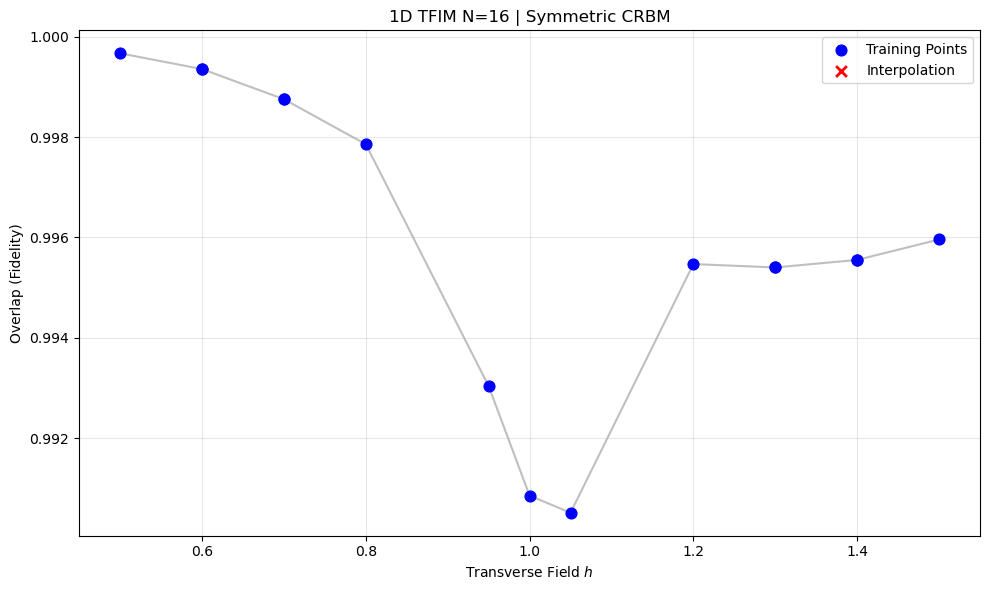

In [14]:
plt.figure(figsize=(10, 6), dpi=100)

supp = df_res[df_res["type"] == "Support"]
nov = df_res[df_res["type"] == "Novel"]

plt.plot(df_res["h"], df_res["overlap"], '-', color='gray', alpha=0.5, zorder=1)
plt.scatter(supp["h"], supp["overlap"], c='blue', label='Training Points', s=60, zorder=2)
plt.scatter(nov["h"], nov["overlap"], c='red', marker='x', label='Interpolation', s=60, zorder=2, linewidth=2)

plt.xlabel(r"Transverse Field $h$")
plt.ylabel("Overlap (Fidelity)")
plt.title(f"1D TFIM N={SYSTEM_SIZE} | Symmetric CRBM")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.ylim(0.95, 1.002) # Adjust based on results
plt.tight_layout()
plt.show()

In [17]:
import numpy as np

print("Generating full Hilbert space for exact evaluation...")
all_states = generate_all_states(SYSTEM_SIZE, device)

# We evaluate on EVERYTHING we have files for
h_eval = sorted(h_available)

results = []
print(f"{'h':<6} | {'Type':<10} | {'Overlap':<10}")
print("-" * 35)

for h_val in h_eval:
    # Construct GT path for every available point
    gt_fname = f"tfim_{SYSTEM_SIZE}_h{h_val:.2f}.npz"
    gt_path = state_dir / gt_fname

    if not gt_path.exists():
        print(f"Skipping h={h_val:.2f} (No GT file)")
        continue

    overlap = compute_overlap(model, h_val, gt_path, all_states)

    # Check if this specific h_val was in our TRAINING list (h_support)
    # Using isclose to avoid float errors (e.g. 1.2000001 vs 1.2)
    is_supp = any(np.isclose(h_val, s, atol=1e-5) for s in h_support)

    pt_type = "Support" if is_supp else "Novel"

    results.append({"h": h_val, "overlap": overlap, "type": pt_type})

    print(f"{h_val:<6.2f} | {pt_type:<10} | {overlap:.5f}")

df_res = pd.DataFrame(results)

Generating full Hilbert space for exact evaluation...


NameError: name 'h_available' is not defined

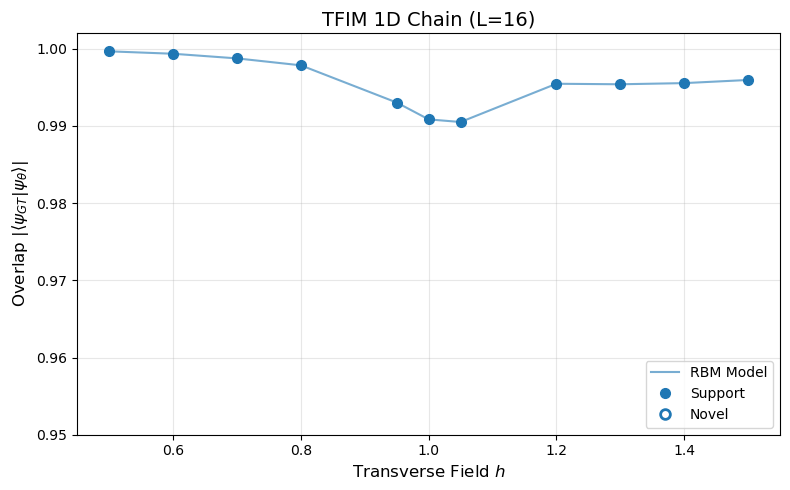

In [16]:
plt.figure(figsize=(8, 5), dpi=100)

# Filter Data
supp = df_res[df_res["type"] == "Support"]
nov  = df_res[df_res["type"] == "Novel"]

# 1. Plot the connecting line
plt.plot(df_res["h"], df_res["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")

# 2. Plot Support points (Filled Blue Circles)
plt.plot(supp["h"], supp["overlap"], 'o', color='tab:blue', markersize=7, label="Support")

# 3. Plot Novel points (Hollow/White-filled Circles) - The "Old" Style
plt.plot(nov["h"], nov["overlap"], 'o', color='tab:blue', markerfacecolor='white',
         markeredgewidth=2, markersize=7, label="Novel")

# Styling
plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_{GT} | \psi_{\theta} \rangle|$", fontsize=12)
plt.title(f"TFIM 1D Chain (L={SYSTEM_SIZE})", fontsize=14)

# The requested limits
plt.ylim(0.95, 1.002)

plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()